# Heuristics

In [1]:
import sys

sys.path.insert(0,"./../tests/numerical") # clue_example is here
sys.path.insert(0,"./../") # clue is here

from clue import *
from numerical_example import *
# import numerical_example as ne
from sympy import RR
import pandas as pd
import time
from alive_progress import alive_bar
from IPython.display import Image, display
import logging
logger = logging.getLogger("clue")
# logger.setLevel(logging.DEBUG)

In [82]:
def get_reductions(example, threshold=1e-4):
    system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
    RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
    system = system.remove_parameters_ic()
    RRsystem = RRsystem.remove_parameters_ic()
    system.construct_matrices(example.matrix)
    RRsystem._lumping_matr[example.matrix] = tuple(M.change_base(RR) for M in system._lumping_matr[example.matrix]) 

    observables = {view_name : [SparsePolynomial.from_string(s, system.variables, system.field) for s in obs_set] for (view_name, obs_set) in example.observables.items()}
    final_observables = {}
    for (view_name,observable) in observables.items():
        if any(not obs.is_linear() for obs in observable):
            logger.error(f"The view ({view_name}) has a non-linear input. Skipping this example.")
        else:
            final_observables[view_name] = observable
    observables = final_observables

    if len(observables) == 0:
        logger.error(f"No valid observables found for this example. Finishing execution.")

    x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
    norm_x0 = norm(x0, ord=2)
    num_points = 1
    threshold = 1e-4
    bound = RRsystem._FODESystem__process_bound(norm_x0, threshold)
    results = {}
    for observable in observables:
        result = []
        nl,nr,ls,rs = RRsystem.find_next_reduction(observables[observable],dev_max=1, bound=bound, num_points=num_points, threshold=threshold, matrix_algorithm=example.matrix)
        result.append((nl,nr,ls,rs))
        while nl != nr:
            nl,nr,ls,rs = RRsystem.find_next_reduction(observables[observable],dev_max=1, bound=bound, num_points=num_points, threshold=threshold, matrix_algorithm=example.matrix, eps_min=rs)
            result.append((nl,nr,ls,rs))
        results[observable] = result
    return results




In [3]:
def size_percentage(example, percentage, threshold):
    
    system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
    RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
    system = system.remove_parameters_ic()
    RRsystem = RRsystem.remove_parameters_ic()
    system.construct_matrices(example.matrix)
    RRsystem._lumping_matr[example.matrix] = tuple(M.change_base(RR) for M in system._lumping_matr[example.matrix]) 

    observables = {view_name : [SparsePolynomial.from_string(s, system.variables, system.field) for s in obs_set] for (view_name, obs_set) in example.observables.items()}
    final_observables = {}
    for (view_name,observable) in observables.items():
        if any(not obs.is_linear() for obs in observable):
            logger.error(f"The view ({view_name}) has a non-linear input. Skipping this example.")
        else:
            final_observables[view_name] = observable
    observables = final_observables

    if len(observables) == 0:
        logger.error(f"No valid observables found for this example. Finishing execution.")

    x0 = array([float(RRsystem.ic.get(v, 0)) for v in RRsystem.variables])
    norm_x0 = norm(x0, ord=2)
    num_points = 1
    threshold = 1e-4
    bound = RRsystem._FODESystem__process_bound(norm_x0, threshold)
    results = {}
    for observable in observables:
        result = []
        nl,nr,ls,rs = RRsystem.find_reduction_given_size(observables[observable],dev_max=1, bound=bound, num_points=num_points, threshold=threshold, matrix_algorithm=example.matrix, allowed_size=percentage)
        result.append((nl,nr,ls,rs)) 
        results[observable] = result
    return results

size_percentage(get_example("BioNetGen_CCP"), 0.25, 1e-6)

{'D13PG': [(23, 10, 0.26706401135146207, 0.2671503280972124)]}

In [58]:
def gen_fig(results):
    from numpy import reshape
    ## Generating graphics
    graphs, titles = [], []
    for observable in results:
        steps = results[observable]
        eps_max = steps[-1][-1]
        epsilons = []
        sizes = []
        for step in steps:
            epsilons.append(step[2]/eps_max)
            epsilons.append(step[3]/eps_max)
            sizes.append(step[0])
            sizes.append(step[1])    
        l = len(epsilons)
        epsilons = reshape(array(epsilons),(l,1))
        sizes = reshape(array(sizes),(1,l))
        graphs.append(OdeResult(t=epsilons, y=sizes, success=True, names=["sizes" ]))
        titles.append(f"Lumping evolution for {str(observable) if len(str(observable)) < 100 else 'something'}")   
    fig = create_figure(graphs, title=titles)
    

In [83]:
def print_res(result):
    cols = {0: 'n_high', 1: 'n_low', 2: 'e_min',3: 'e_max'}
    for obs in result:
        df = pd.DataFrame.from_records(result[obs])
        df.rename(columns=cols, inplace=True)
        index = df.index
        index.name = obs.strip()
        print(df)

In [20]:
example = get_example("BioNetGen_CCP")
system = FODESystem(file=example.path_model(), read_ic = True, parser=example.read).remove_parameters_ic()
RRsystem = FODESystem(file=example.path_model(), read_ic = True, parser=example.read, field = RR).remove_parameters_ic()
system = system.remove_parameters_ic()
RRsystem = RRsystem.remove_parameters_ic()
system.construct_matrices(example.matrix)
RRsystem._lumping_matr[example.matrix] = tuple(M.change_base(RR) for M in system._lumping_matr[example.matrix]) 
system.size


87

# Polynomial


## BioNetGen_CCP

In [55]:
example = get_example("BioNetGen_CCP")
results = get_reductions(example,threshold)


In [56]:
print_res(results)

       n_min  n_max     e_min     e_max
D13PG                                  
0         88     30  0.000000  0.000086
1         30     28  0.105476  0.105562
2         28     26  0.106061  0.106144
3         26     24  0.117442  0.117525
4         24     23  0.258001  0.258084
5         23     10  0.267105  0.267183
6         10      9  0.485492  0.485570
7          9      5  0.728093  0.728164
8          5      4  0.982877  0.982942
9          4      2  1.365015  1.365071
10         2      2  2.828338  2.828427


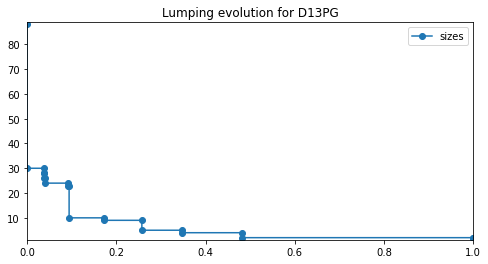

In [57]:
gen_fig(results)

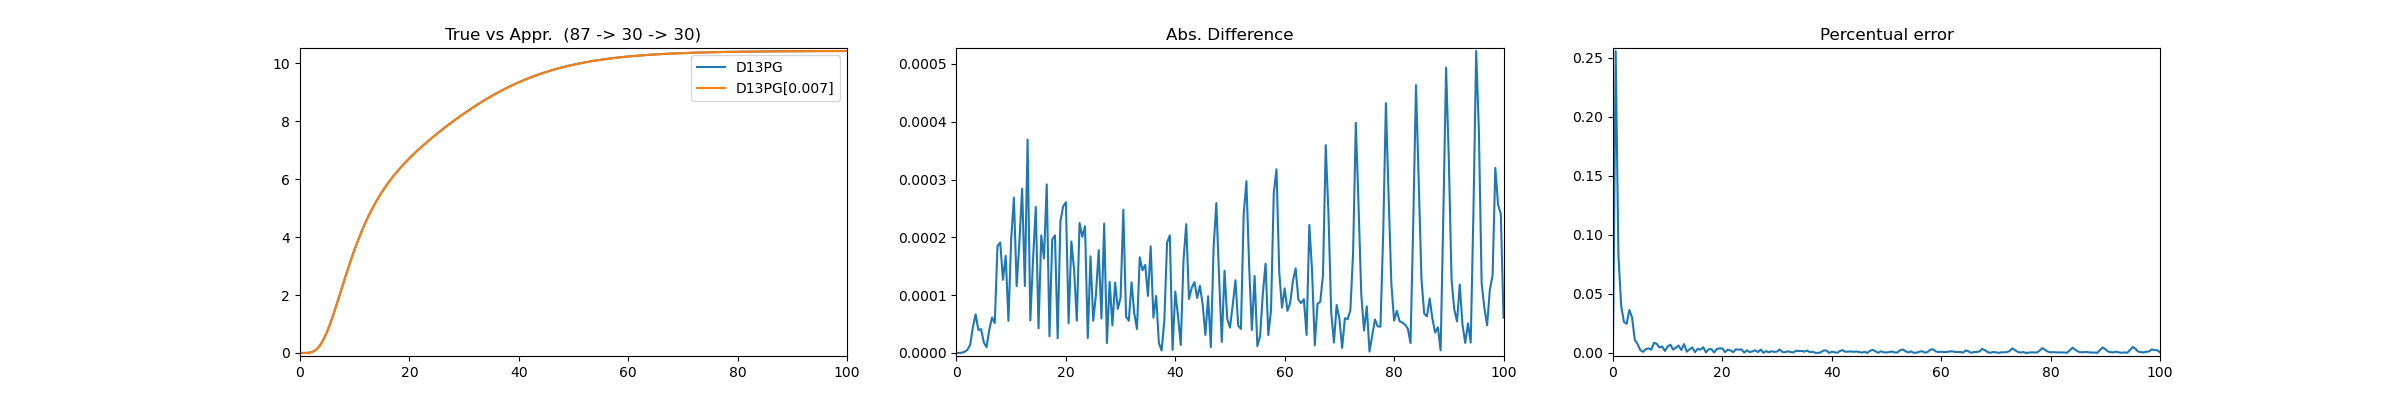

In [2]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/images/BioNetGen_CCP[percentages][r=polynomial,m=polynomial][D13PG#0.007].png',width=1400))

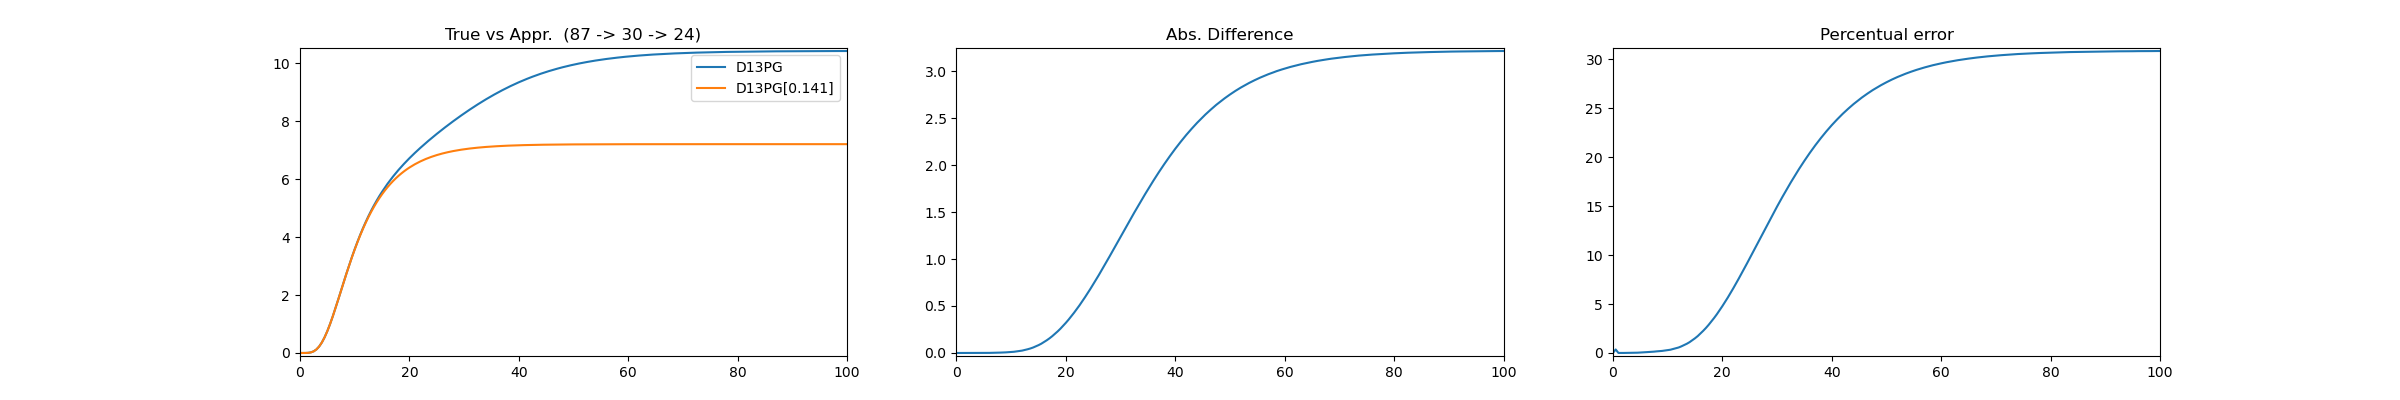

In [3]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/images/BioNetGen_CCP[percentages][r=polynomial,m=polynomial][D13PG#0.141].png',width=1400))

## NIHMS80246_S6

In [61]:
res = get_reductions(get_example("NIHMS80246_S6"))

In [62]:
print_res(res)

     n_min  n_max     e_min     e_max
S2P                                  
0       27     19  0.000000  0.000076
1       19     17  0.022312  0.022388
2       17     14  0.023381  0.023452
3       14      9  0.029957  0.030028
4        9      8  0.128491  0.128560
5        8      7  0.279449  0.279539
6        7      1  0.312984  0.313050
7        1      1  0.313050  0.313050


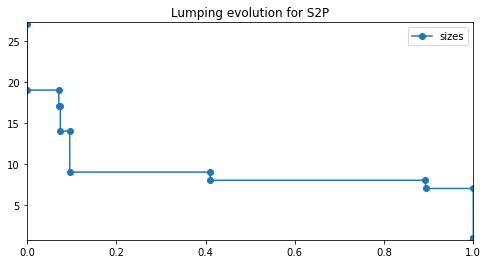

In [63]:
gen_fig(res)

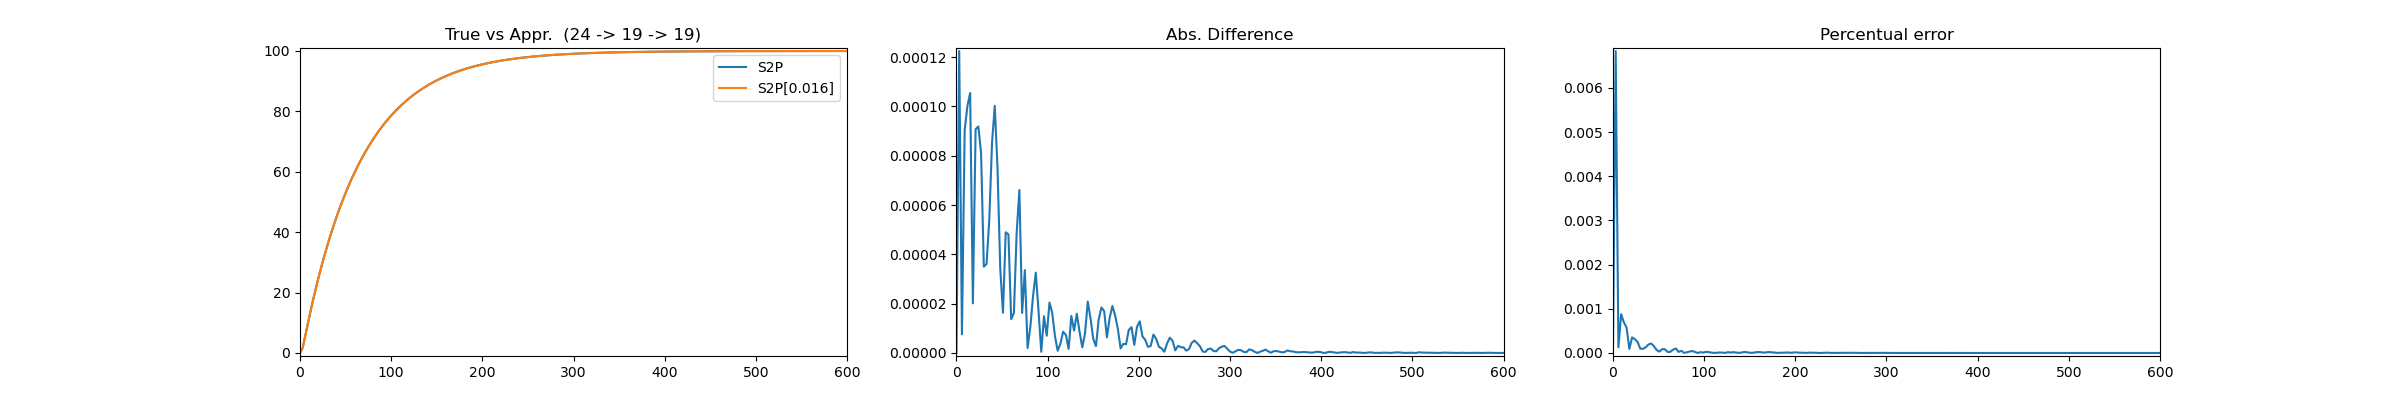

In [4]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/images/NIHMS80246_S6[percentages][r=polynomial,m=polynomial][S2P#0.016].png',width=1400))


##

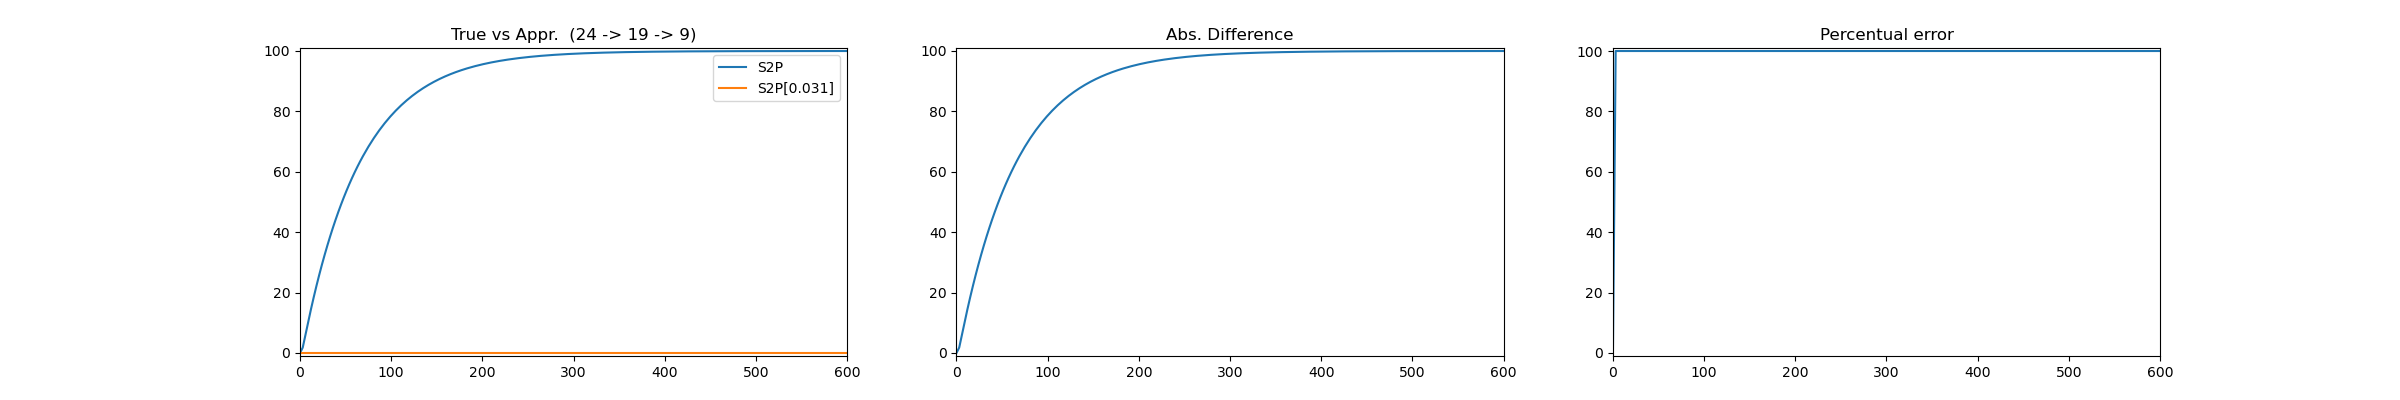

In [5]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/images/NIHMS80246_S6[percentages][r=polynomial,m=polynomial][S2P#0.031].png',width=1400))


## journal.pcbi.1003544.s006

In [64]:
res = get_reductions(get_example("journal.pcbi.1003544.s006"), threshold=1e-8)

In [65]:
print_res(res)

    n_min  n_max     e_min     e_max
RC                                  
0      86      2  0.001561  0.001659
1       2      1  0.399555  0.399653
2       2      2  0.399653  0.399653


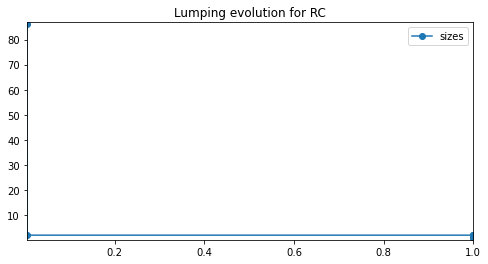

In [66]:
gen_fig(res)

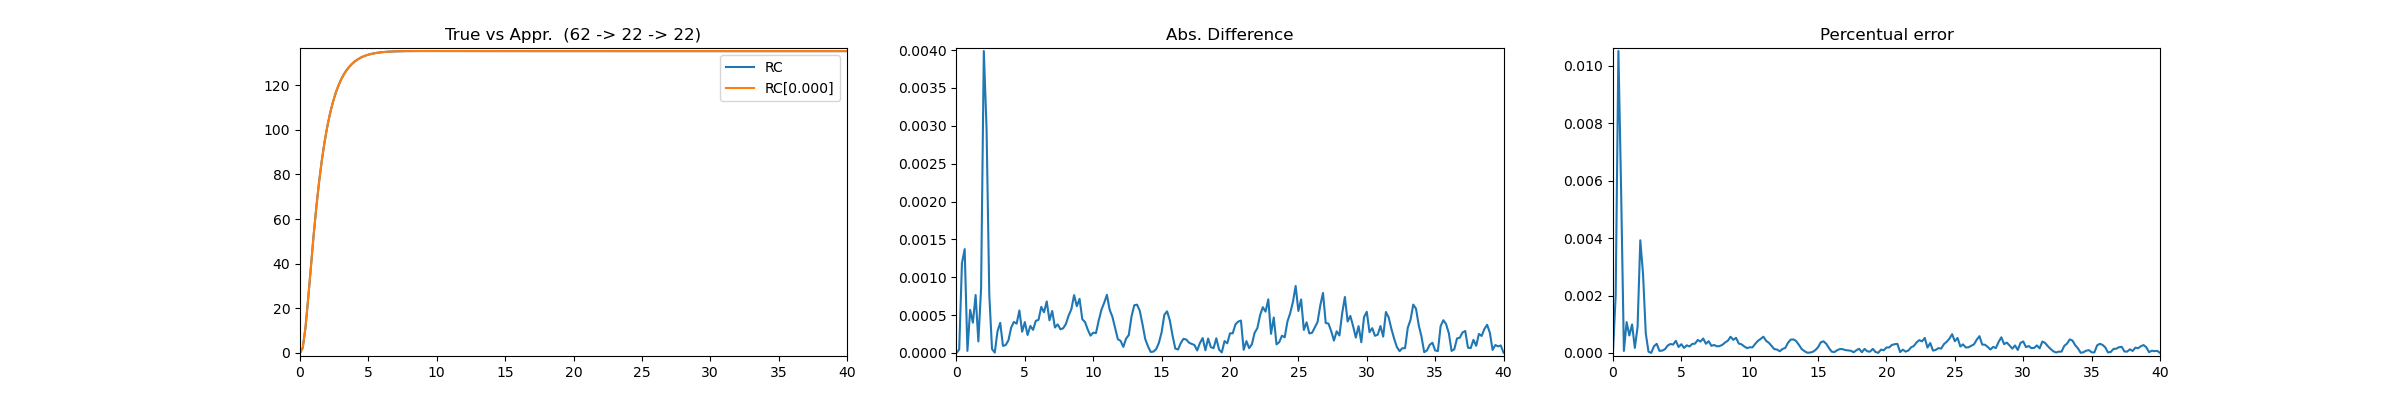

In [6]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/images/journal.pcbi.1003544.s006[percentages][r=polynomial,m=polynomial][RC#0.000].png',width=1400))


# Rational

## BIOMD087

In [67]:
result = get_reductions(get_example("BIOMD*087"))


In [68]:
print_res(result)

       n_min  n_max     e_min  e_max
Ctelo                               
0          8      1  0.999939    1.0
1          1      1  1.000000    1.0
       n_min  n_max     e_min     e_max
ssDNA                                  
0         44      2  0.999939  1.000031
1          2      1  2.999939  3.000000
2          1      1  3.000000  3.000000
       n_min  n_max     e_min  e_max
Cdc13                               
0          8      1  0.999939    1.0
1          1      1  1.000000    1.0


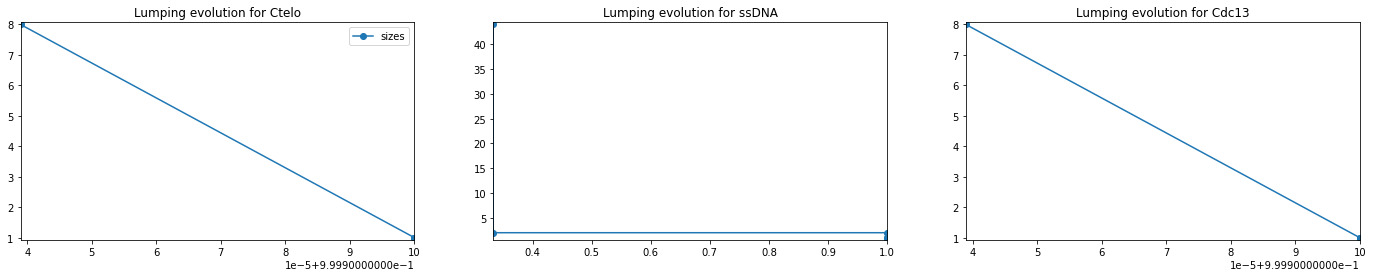

In [69]:
gen_fig(result)

## BIOMD088 [Simulation Fails]

In [84]:
result = get_reductions(get_example("BIOMD*088"))


In [85]:
print_res(result)

            n_high  n_low      e_min      e_max
Rho_kinase                                     
0               95     93   0.000325   0.000406
1               93     73   0.019960   0.020041
2               73     71   0.099967   0.100048
3               71     70   0.239756   0.239837
4               70     69   0.619932   0.620013
5               69     68   2.919934   2.920013
6               68     65   3.502543   3.502612
7               65     64   4.899956   4.900024
8               64     62   5.999941   6.000003
9               62     58   6.348685   6.348743
10              58     50   7.339990   7.340047
11              50     42   7.879978   7.880032
12              42     41  10.000065  10.000116
13              41     39  17.319985  17.320071
14              39     38  19.599989  19.600050
15              38     18  20.000000  20.000051
16              18      1  21.269683  21.269760
17               1      1  21.269760  21.269760


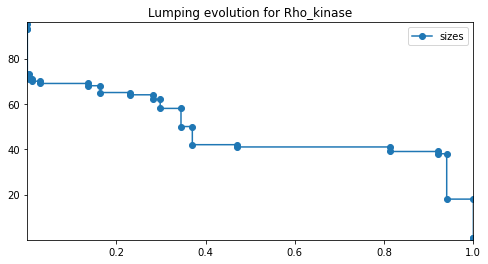

In [86]:
gen_fig(result)

## BIOMD437

In [73]:
res = get_reductions(get_example("BIOMD*437"))


In [74]:
print_res(res)

          n_min  n_max          e_min          e_max
frq_mRNA                                            
0            21     12       0.000000       0.000083
1            12     11      35.555495      35.555578
2            11      5     106.666655     106.666738
3             5      4     333.333287     333.333370
4             4      2     499.999947     500.000030
5             2      1  711111.111028  711111.111111
6             1      1  711111.111111  711111.111111
          n_min  n_max     e_min  e_max
frq_gene                               
0             1      1  0.999939    1.0


/home/alexander/CLUE/notebooks/./../clue/simulations.py:194: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  a.title.set_text(title[i]); a.set_xlim(*xinterval[i]); a.set_ylim(*yinterval[i])


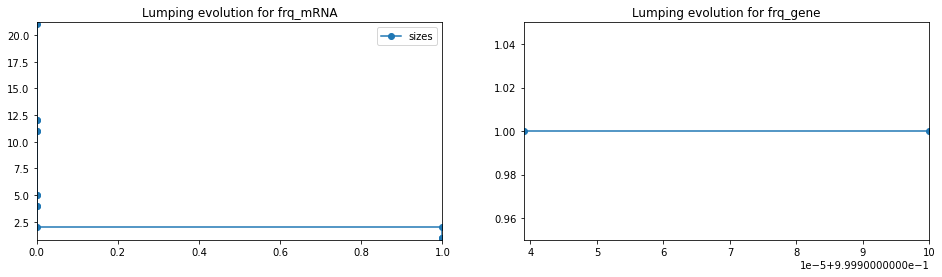

In [75]:
gen_fig(res)

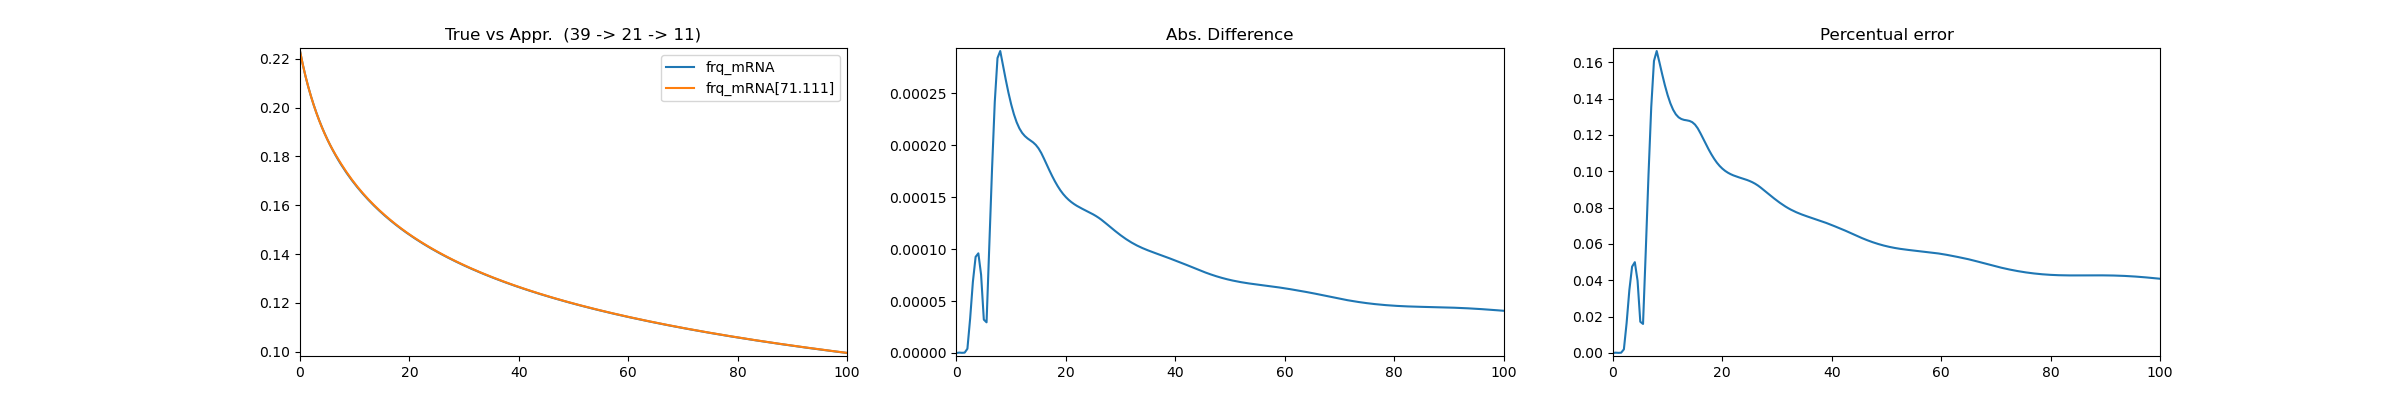

In [9]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*437[percentages][r=rational,m=rational][frq_mRNA#71.111].png',width=1400))


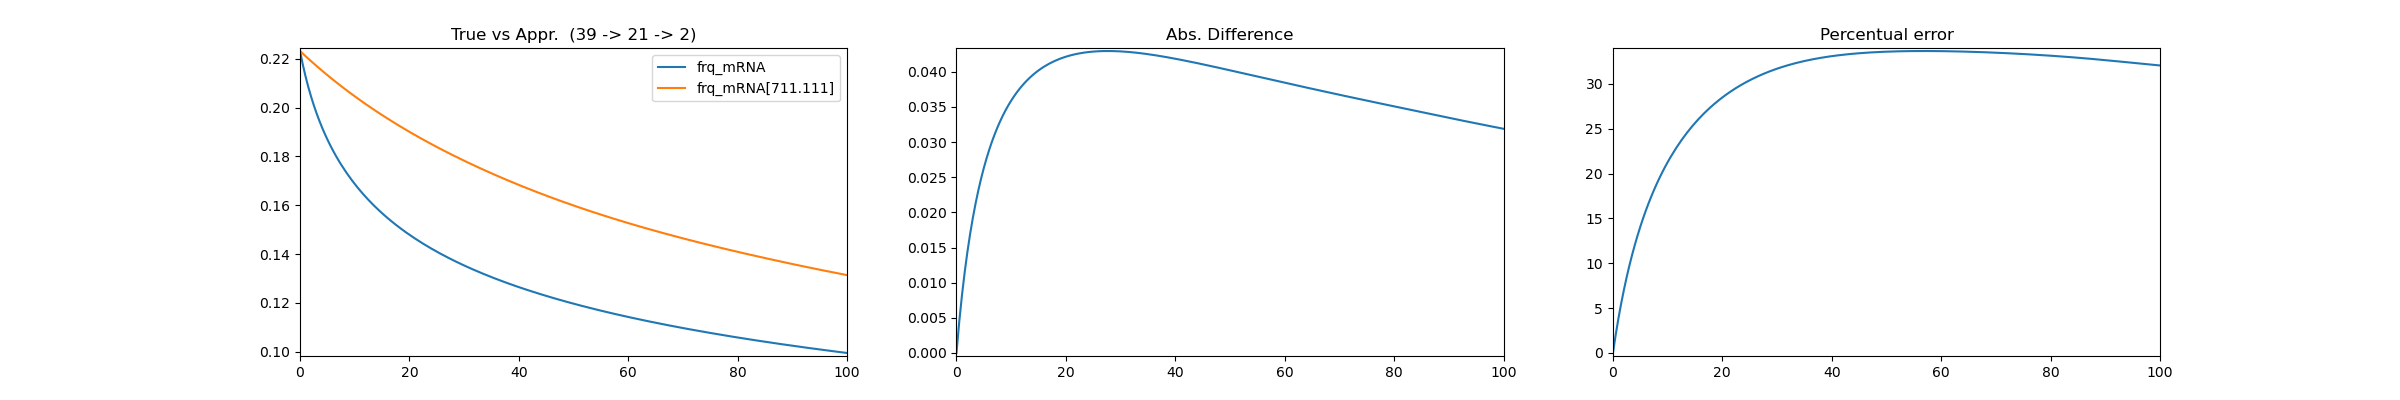

In [10]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*437[percentages][r=rational,m=rational][frq_mRNA#711.111].png',width=1400))


## BIOMD448

In [76]:
res = get_reductions(get_example("BIOMD*448"))

In [77]:
print_res(res)

        n_min  n_max    e_min     e_max
VIEW_0                                 
0          19     15  0.01593  0.015991
1          15      1  0.99994  1.000000
2           1      1  1.00000  1.000000


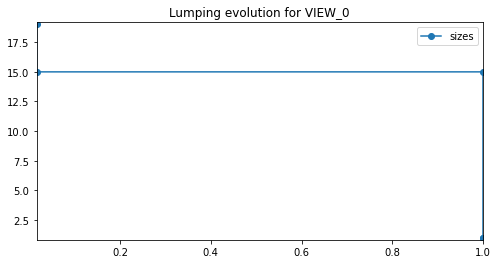

In [78]:
gen_fig(res)

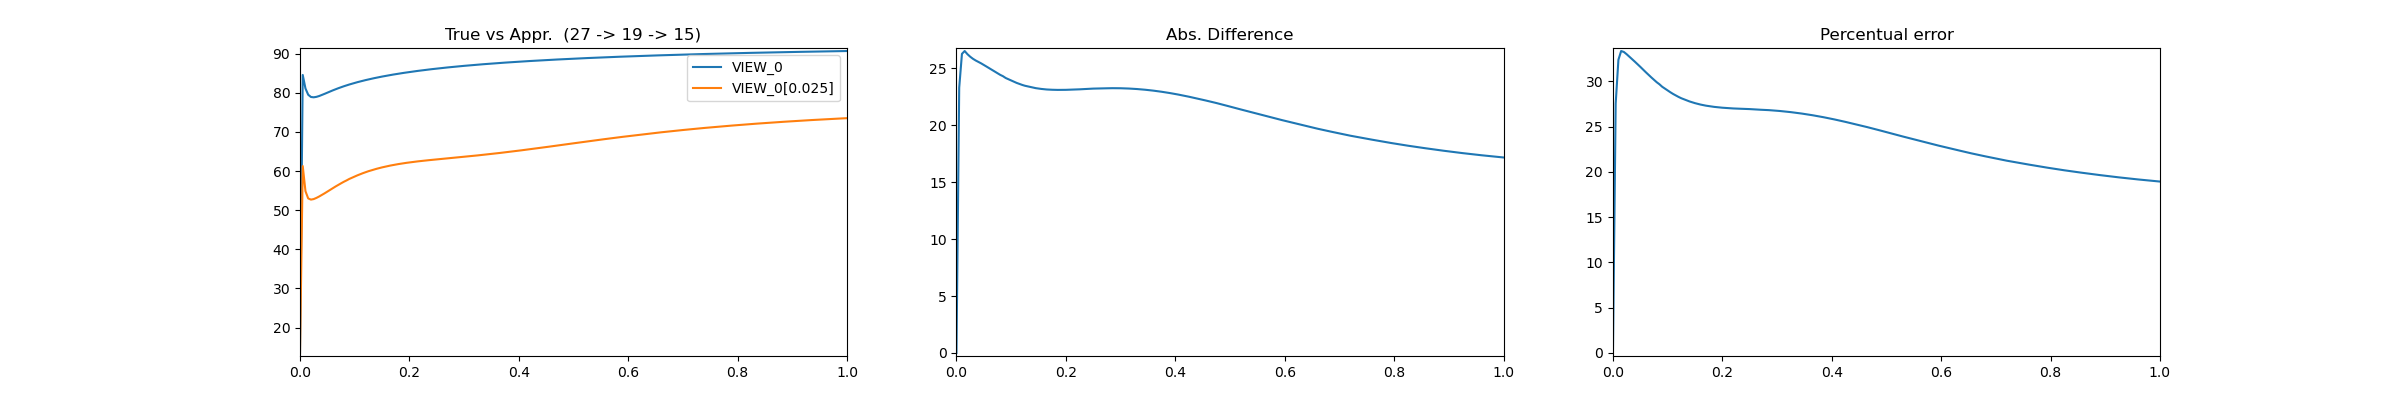

In [11]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*448[percentages][r=sympy,m=auto_diff][VIEW_0#0.025].png',width=1400))


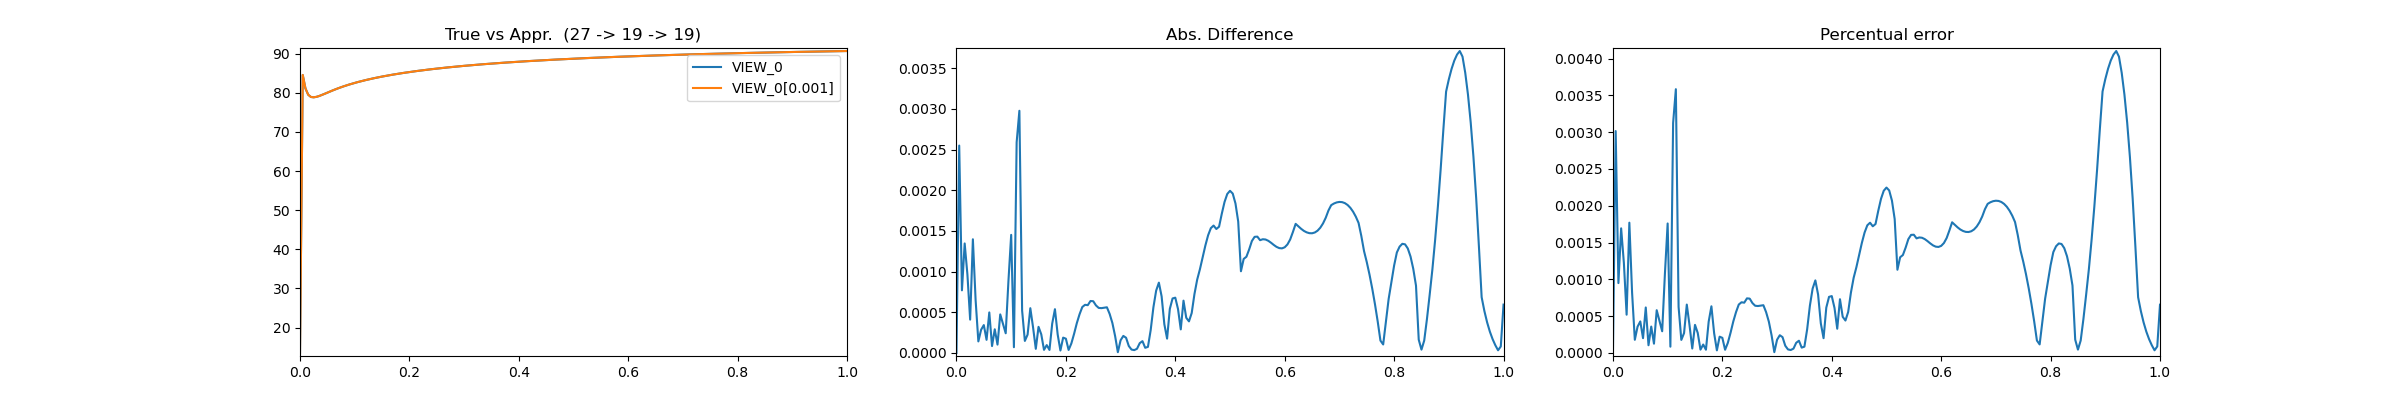

In [12]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*448[percentages][r=sympy,m=auto_diff][VIEW_0#0.001].png',width=1400))



## BIOMD488

In [70]:
res = get_reductions(get_example("BIOMD*488"))


In [71]:
print_res(res)

       n_min  n_max         e_min         e_max
GSK3b                                          
0         64     63  1.999979e+00  2.000064e+00
1         63     61  5.999937e+00  6.000022e+00
2         61     60  4.999998e+01  5.000007e+01
3         60     59  1.499999e+02  1.500000e+02
4         59     49  3.000000e+02  3.000000e+02
5         49     45  7.500000e+04  7.500000e+04
6         45     42  4.500000e+05  4.500000e+05
7         42     38  7.500000e+05  7.500000e+05
8         38      3  1.500000e+06  1.500000e+06
9          3      1  1.500000e+09  1.500000e+09
10         1      1  1.500000e+09  1.500000e+09
     n_min  n_max         e_min         e_max
ROS                                          
0       64     63  1.999961e+00  2.000024e+00
1       63     61  5.999945e+00  6.000009e+00
2       61     60  4.999996e+01  5.000002e+01
3       60     59  1.500000e+02  1.500001e+02
4       59     49  3.000000e+02  3.000000e+02
5       49     45  7.500000e+04  7.500000e+04
6       

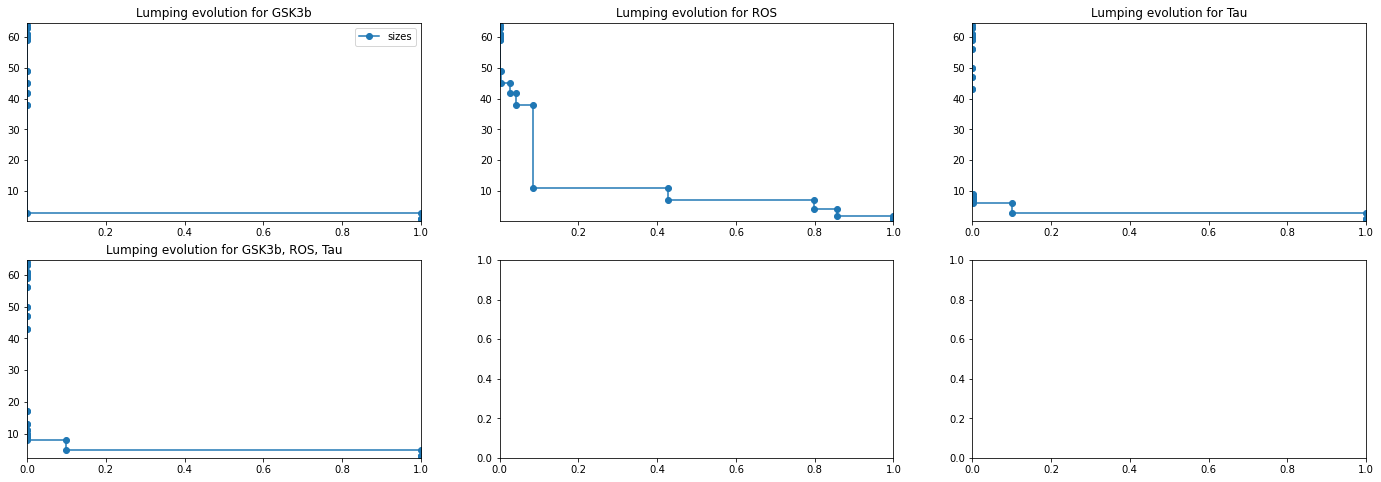

In [72]:
gen_fig(res)

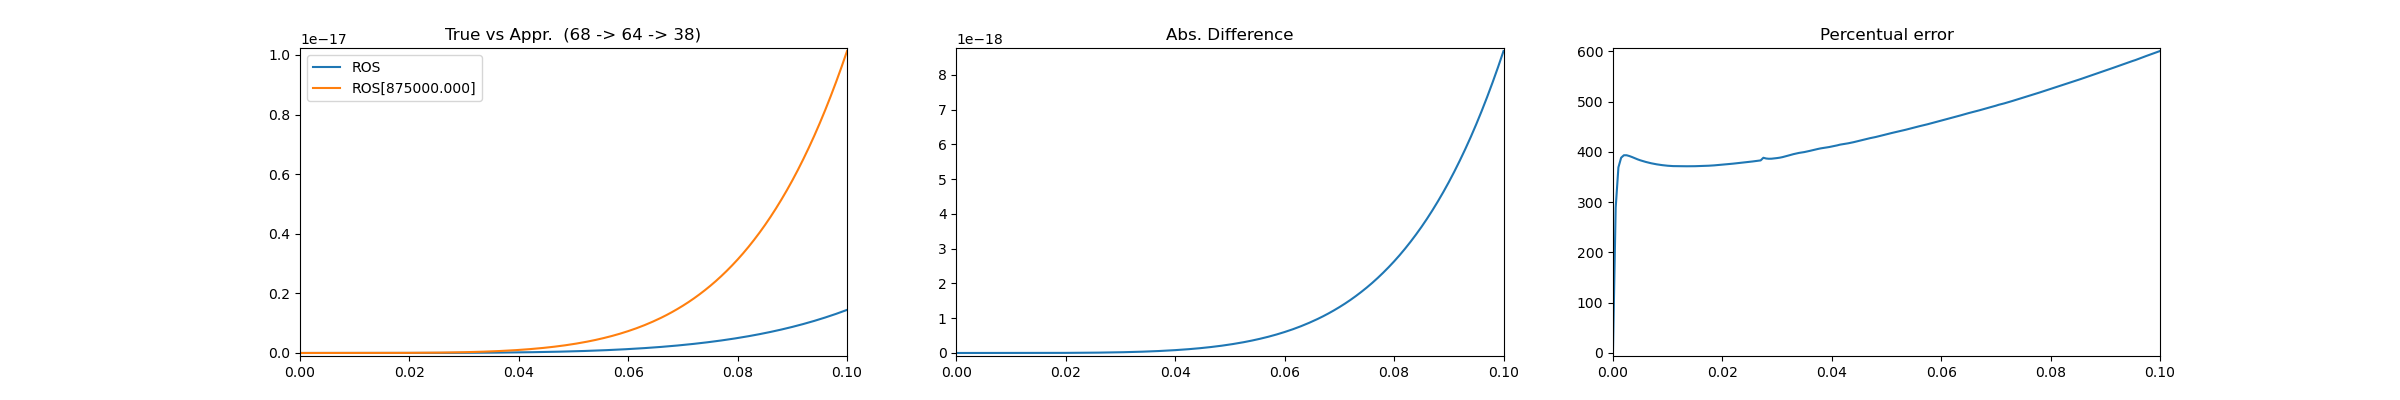

In [16]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*488[percentages][r=rational,m=rational][ROS#875000.000].png',width=1400))


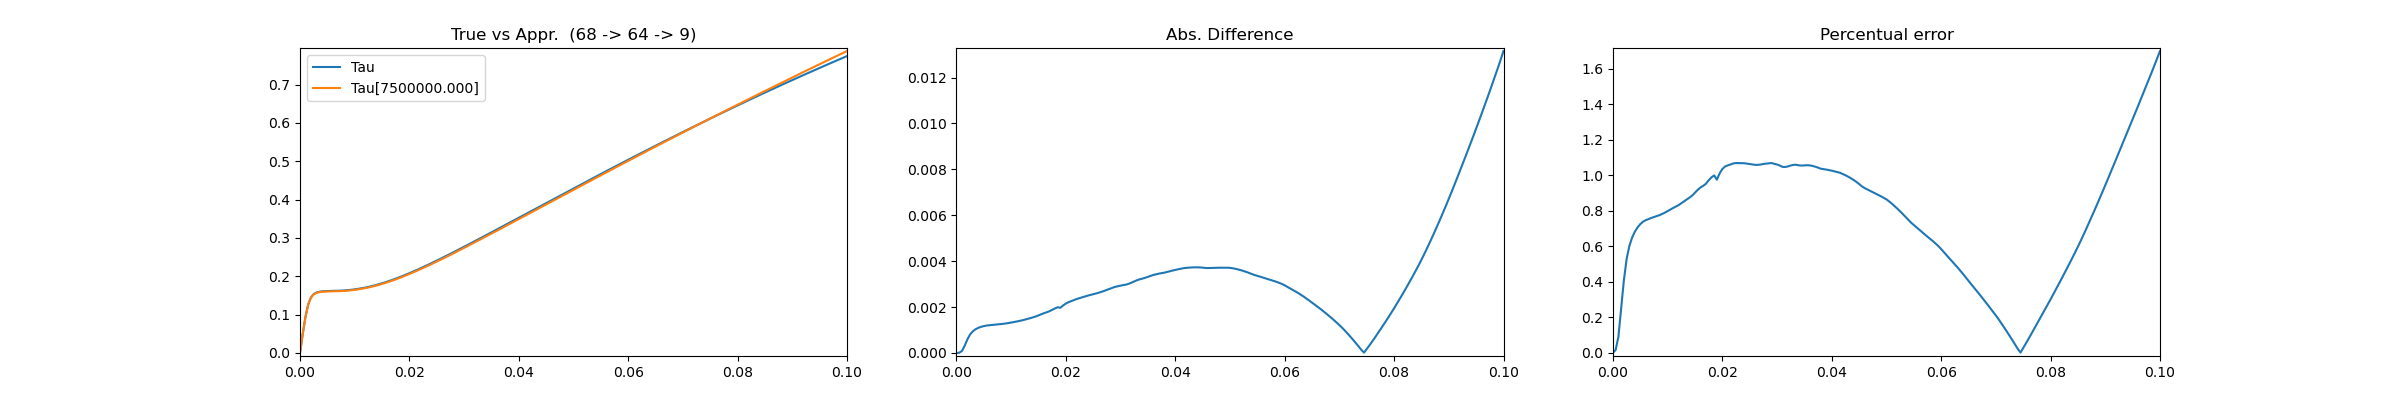

In [17]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*488[percentages][r=rational,m=rational][Tau#7500000.000].png',width=1400))


## BIOMD634

In [79]:
res = get_reductions(get_example("BIOMD*634"))

In [80]:
print_res(res)

        n_min  n_max         e_min         e_max
VIEW_0                                          
0          64     63  1.999979e+00  2.000064e+00
1          63     61  5.999937e+00  6.000022e+00
2          61     60  4.999998e+01  5.000007e+01
3          60     59  1.499999e+02  1.500000e+02
4          59     49  3.000000e+02  3.000000e+02
5          49     45  7.500000e+04  7.500000e+04
6          45     42  4.500000e+05  4.500000e+05
7          42     38  7.500000e+05  7.500000e+05
8          38      3  1.500000e+06  1.500000e+06
9           3      1  1.500000e+09  1.500000e+09
10          1      1  1.500000e+09  1.500000e+09
        n_min  n_max         e_min         e_max
VIEW_1                                          
0          64     63  1.999961e+00  2.000024e+00
1          63     61  5.999945e+00  6.000009e+00
2          61     60  4.999996e+01  5.000002e+01
3          60     59  1.500000e+02  1.500001e+02
4          59     49  3.000000e+02  3.000000e+02
5          49     45

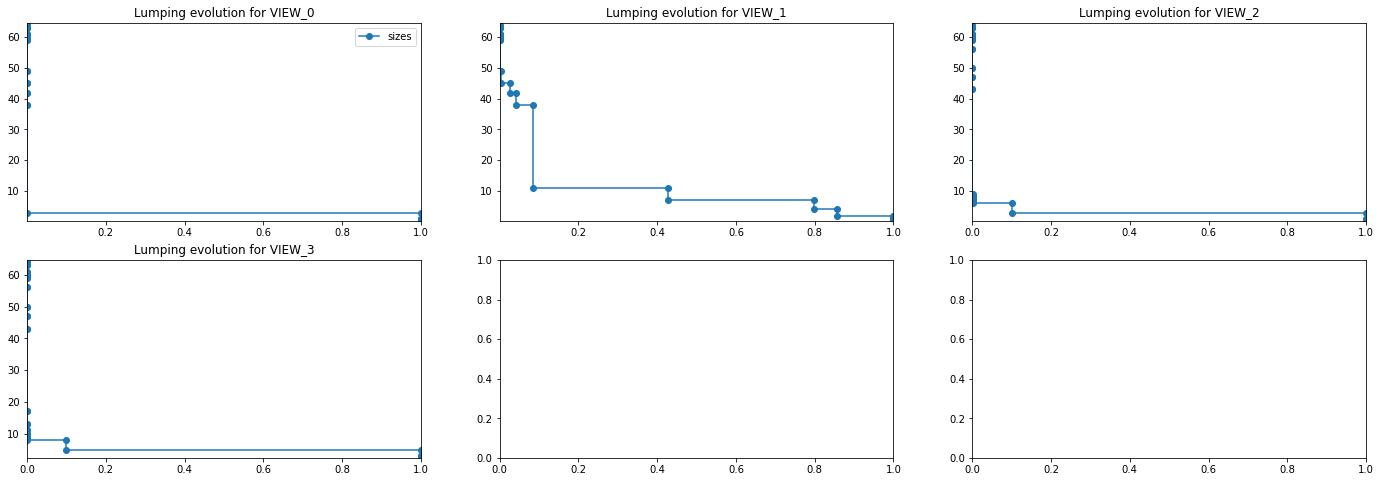

In [81]:
gen_fig(res)

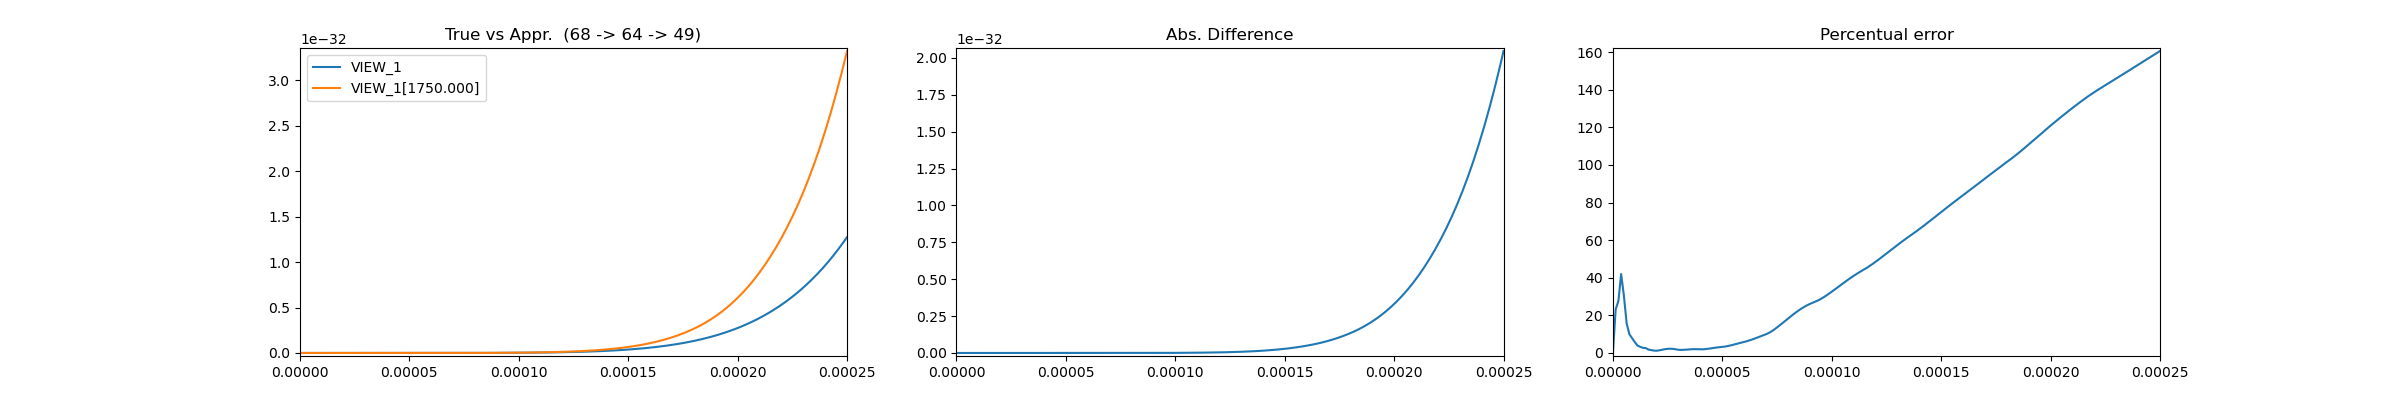

In [13]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*634[percentages][r=rational,m=rational][VIEW_1#1750.000].png',width=1400))


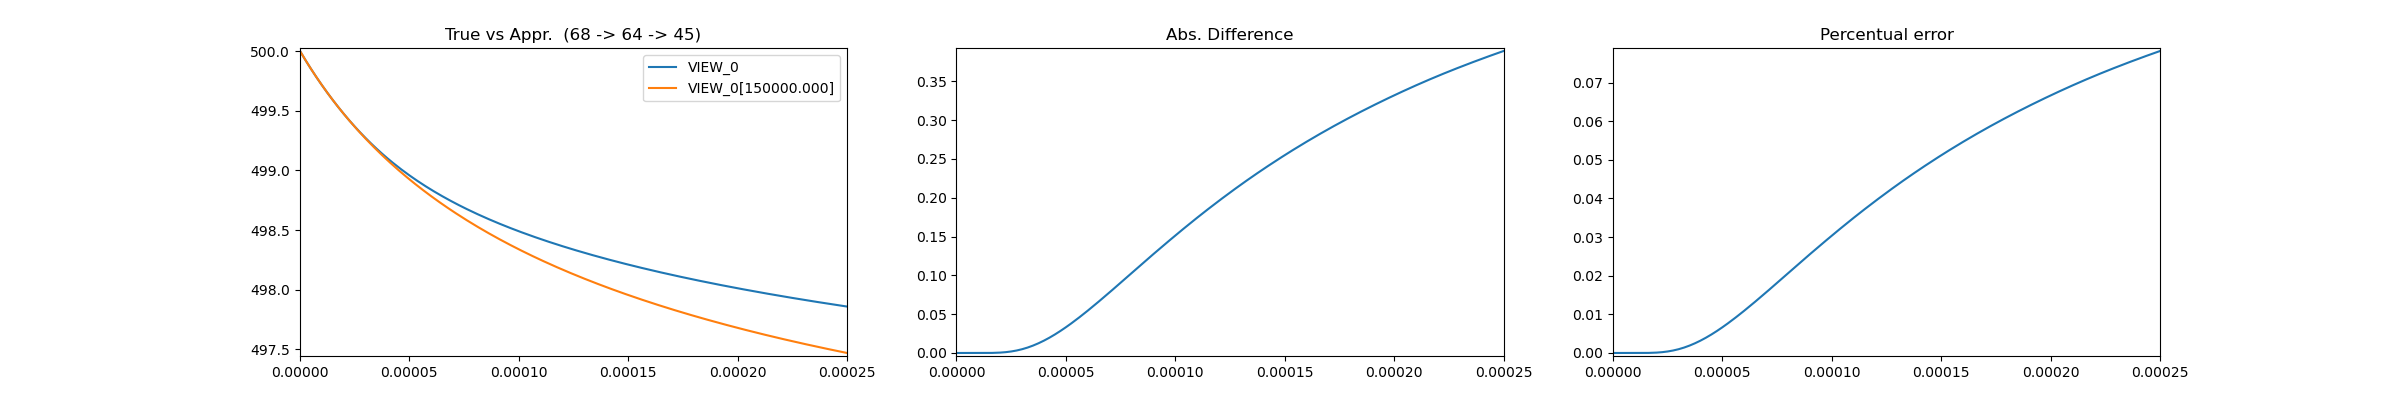

In [14]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*634[percentages][r=rational,m=rational][VIEW_0#150000.000].png',width=1400))


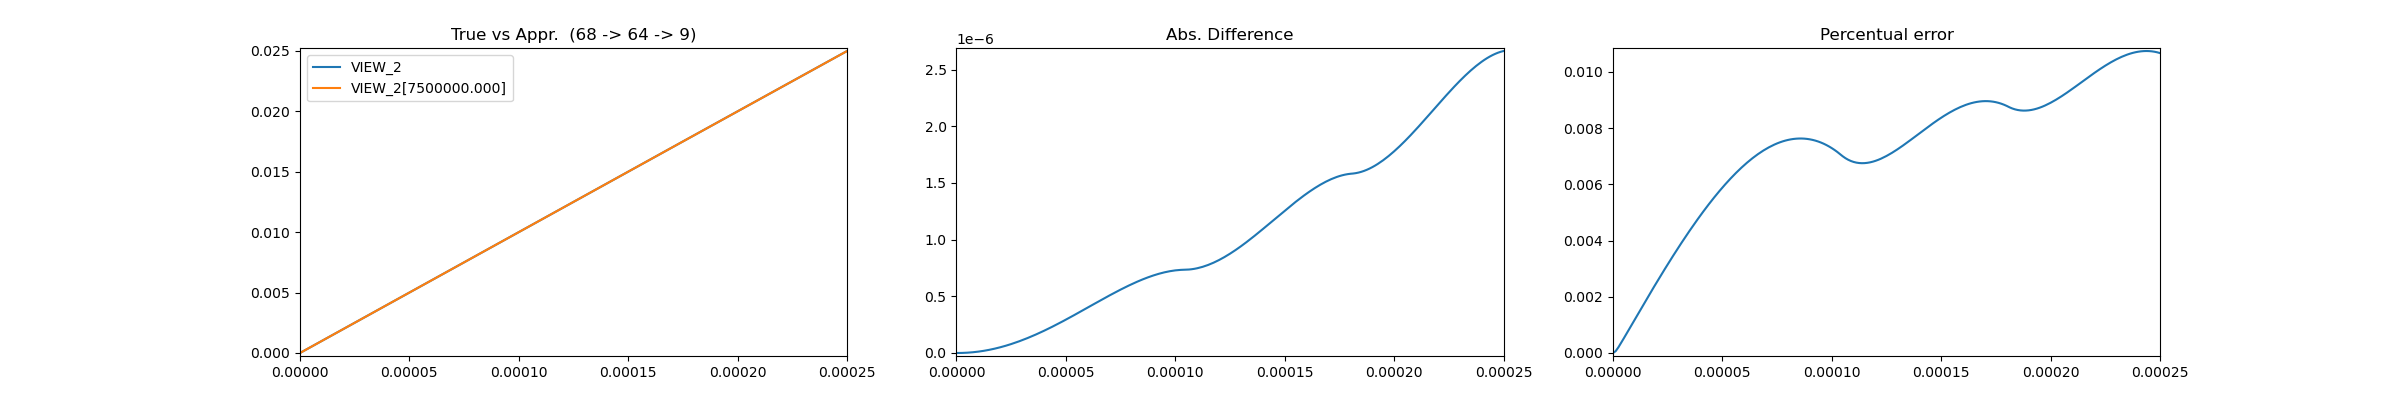

In [15]:
display(Image(filename='/home/alexander/CLUE/tests/numerical/rational/images/BIOMD*634[percentages][r=rational,m=rational][VIEW_2#7500000.000].png',width=1400))
